In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP

import models
from data_frame import DataFrame, MaxFiller, MAGNITUDES, COLORS
from histogram_plotter import HistPlotter
from utils import load_config, load_model

DATAPATH = "../dataframes/experiment3/MG_3_components_3.csv"
columns_25 = [f"percentile_{i}" for i in np.arange(5,100,5)]
columns_100 = [f"percentile_{i}" for i in np.arange(1,100,1)]

df = pd.read_csv(DATAPATH, index_col=0)
df, indices = df.loc[(df["split"] == "test")], df.index

<b>Wykresy korelacji</b>

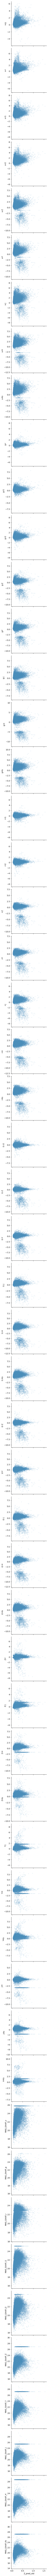

In [223]:
sns.pairplot(df, x_vars=["Z_pred_std"], y_vars=COLORS + MAGNITUDES, kind="scatter", height=3.5, plot_kws=dict(s=15, alpha=0.1))

<b>Redukcja wymiarów T-sne + Clustering HDBSCAN</b>

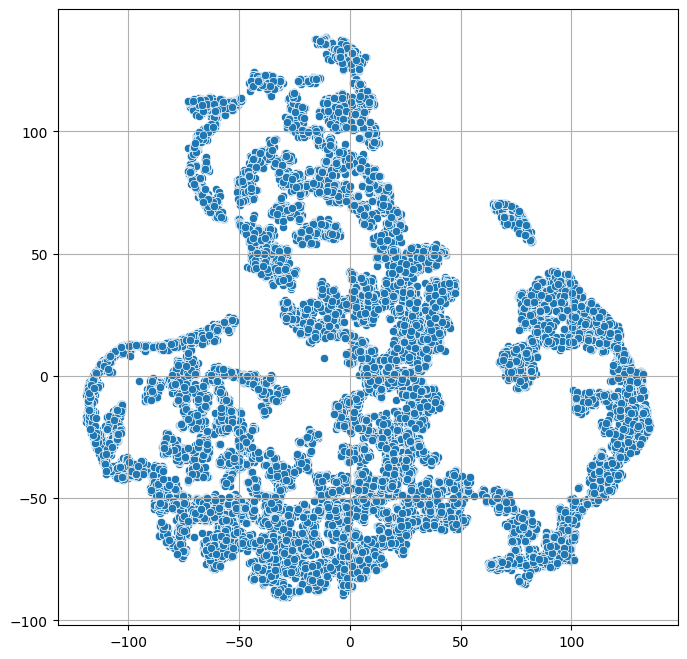

In [114]:
X_scaled = StandardScaler().fit_transform(df[columns_100])
X_emb = TSNE(n_components=2, perplexity=50, learning_rate=200, max_iter=5000,
             init="random", metric="cosine", random_state=0, n_jobs=-1).fit_transform(X_scaled)

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1])
plt.grid()
plt.show()

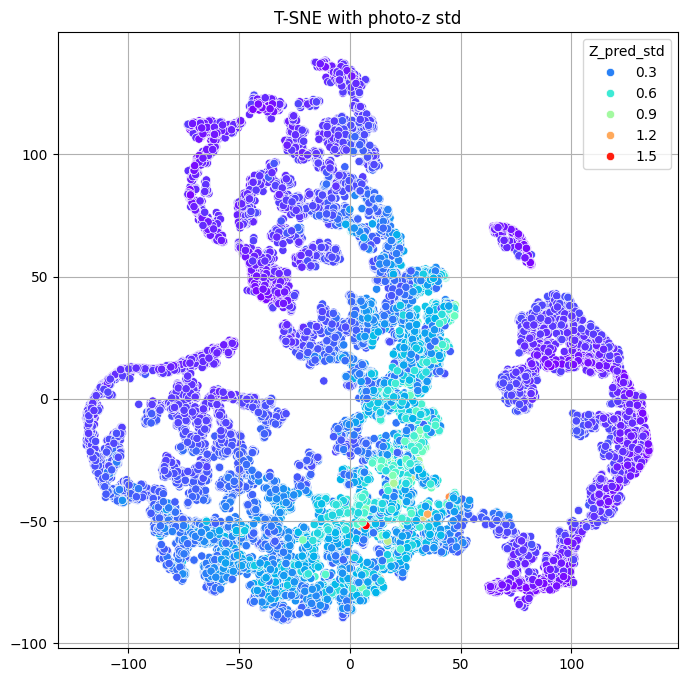

In [115]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred_std"], palette="rainbow")
plt.grid()
plt.title("T-SNE with photo-z std")
plt.show()

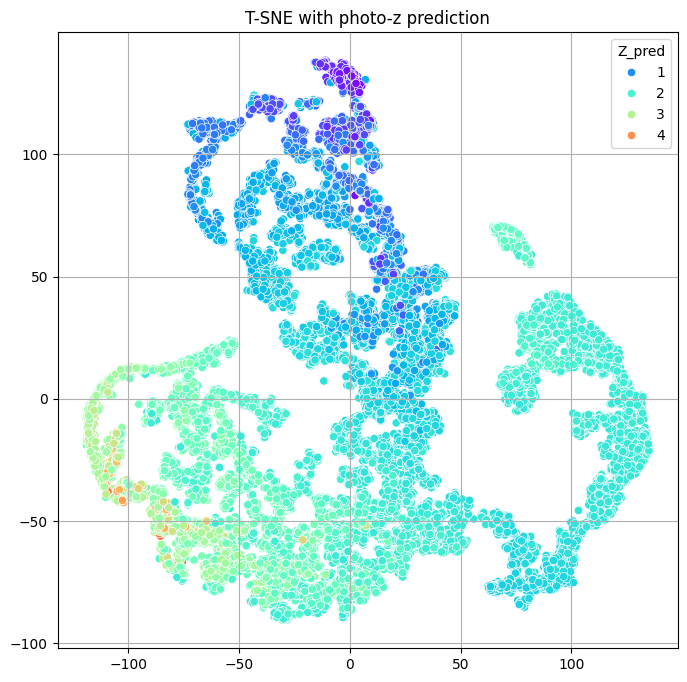

In [116]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred"], palette="rainbow")
plt.grid()
plt.title("T-SNE with photo-z prediction")
plt.show()

In [219]:
# clusters = HDBSCAN(min_cluster_size=200, min_samples=15, metric="euclidean").fit_predict(X_emb)

# print(pd.DataFrame(clusters).value_counts())

# plt.figure(figsize=(8,8))
# sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=clusters.astype(str), palette="tab20b")
# plt.grid()
# plt.title("T-SNE with cluster")
# plt.show()

<b>Redukcja wymiarów UMAP + Clustering HDBSCAN</b>

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


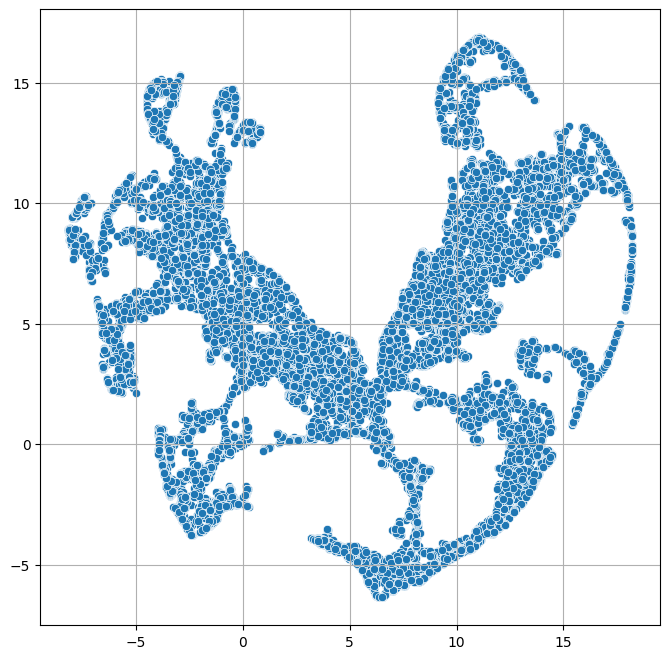

In [200]:
X_scaled = StandardScaler().fit_transform(df[columns_100])
X_emb = UMAP(n_neighbors=10, min_dist=0.05, metric="cosine", random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1])
plt.grid()
plt.show()

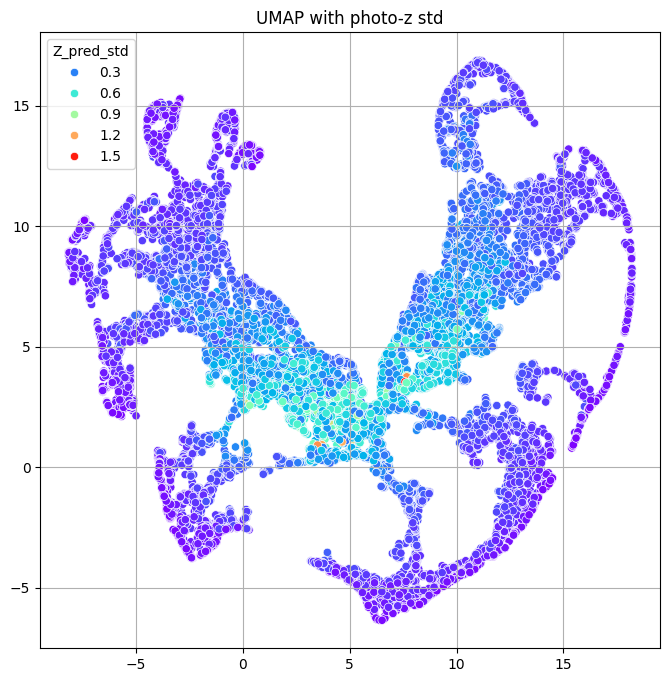

In [201]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred_std"], palette="rainbow")
plt.grid()
plt.title("UMAP with photo-z std")
plt.show()

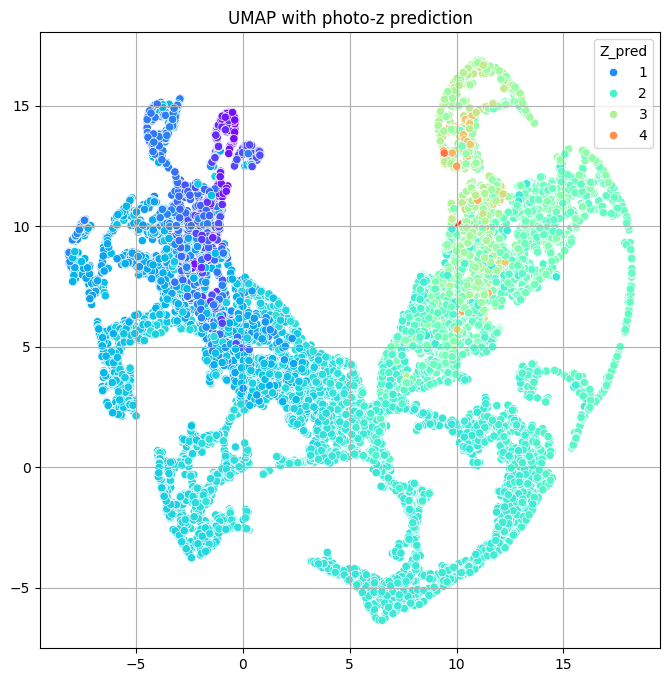

In [202]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred"], palette="rainbow")
plt.grid()
plt.title("UMAP with photo-z prediction")
plt.show()

In [221]:
# clusters = HDBSCAN(min_cluster_size=260, min_samples=30, metric="euclidean").fit_predict(X_emb)

# print(pd.DataFrame(clusters).value_counts())

# plt.figure(figsize=(8,8))
# sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=clusters.astype(str), palette="tab20")
# plt.grid()
# plt.title("UMAP with cluster")
# plt.show()

<b>Histogramy clustrów</b>

In [217]:
config_path = "configs/config.yml"
config = load_config(config_path)

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

dframe = DataFrame(filePath, "QSO", MaxFiller())
X_train, y_train = dframe.get_train_dataset()
features = dframe.features

scaler = StandardScaler()
scaler.fit(X_train)

modelPath = f"../models/experiment2/MG_{config["num_components"]}_components_3/variables/variables"
model = load_model(modelPath, models.MixtureGaussian, dframe, config)

2025-10-10 16:31:19.192036: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Chi^2: 391.5024101036244


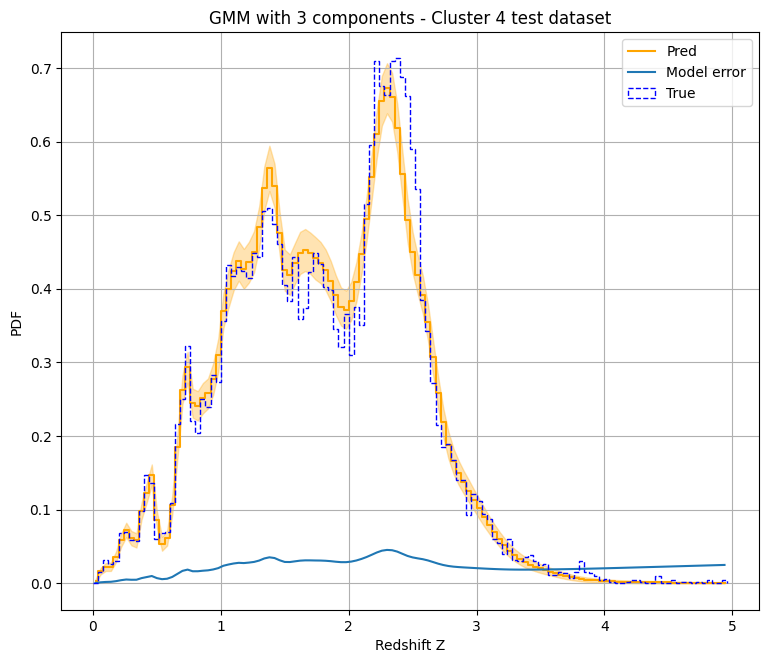

Chi^2: 613.2890194006964


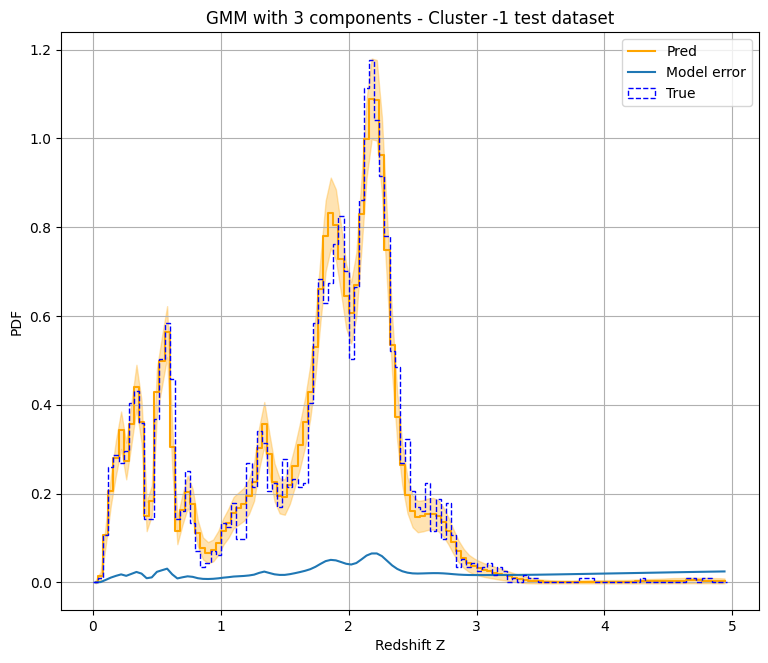

Chi^2: 10045.811267276262


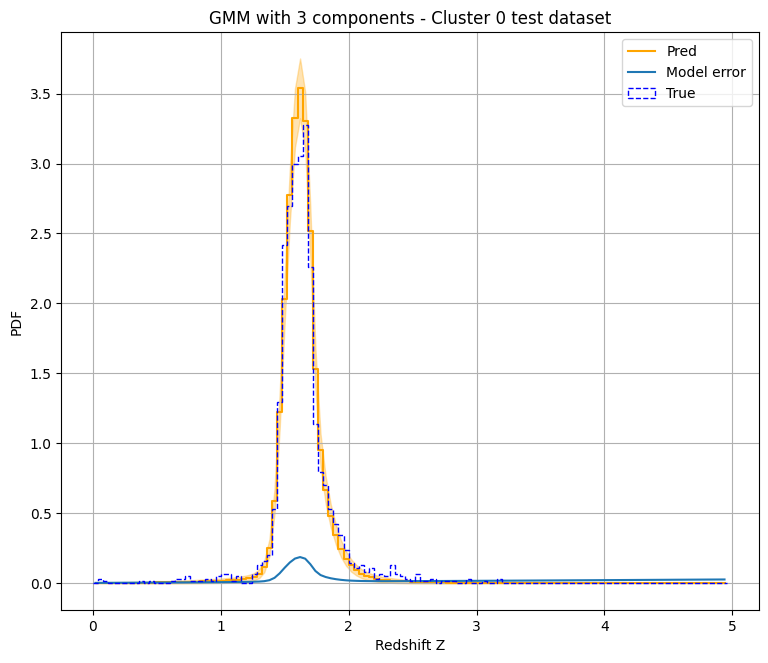

Chi^2: 1891.8374879759313


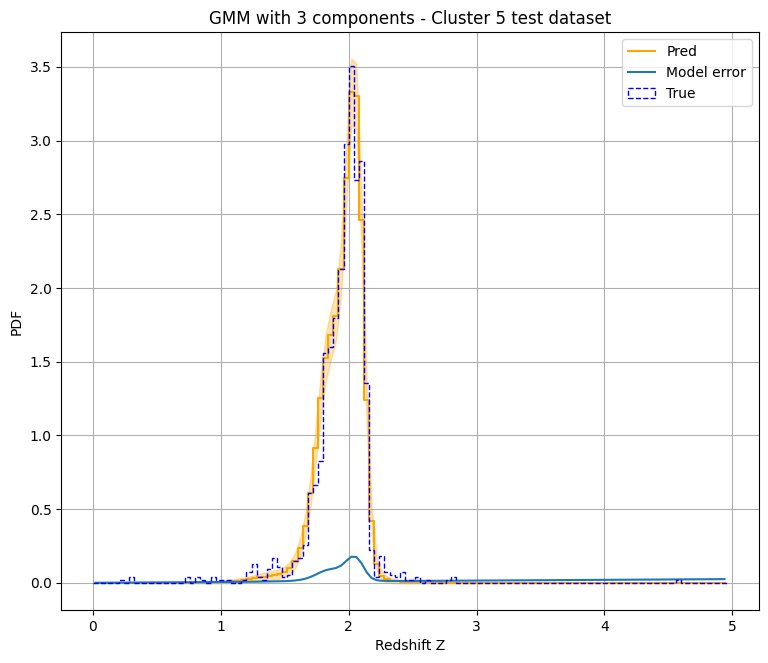

Chi^2: 844.5896738146998


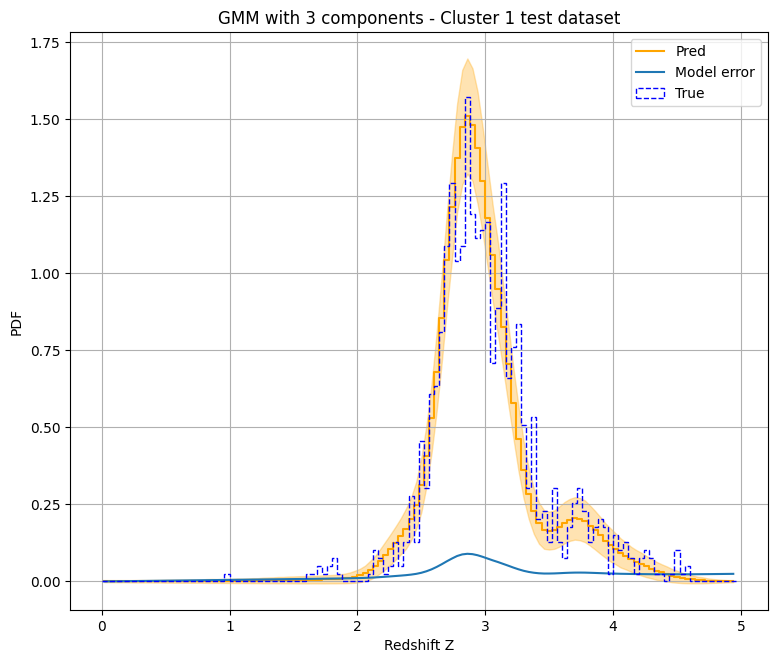

Chi^2: 1101.6040650931857


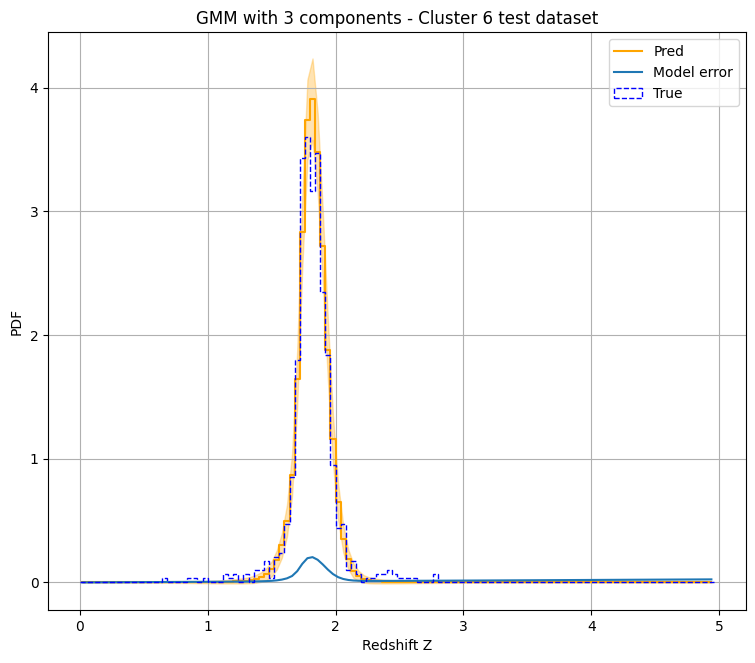

Chi^2: 2291.0884313721344


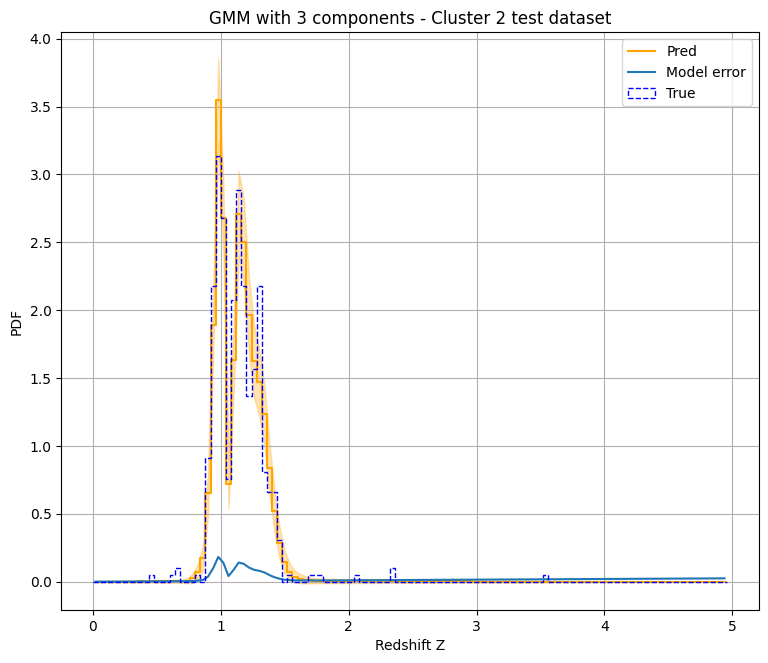

Chi^2: 1124.0981256686123


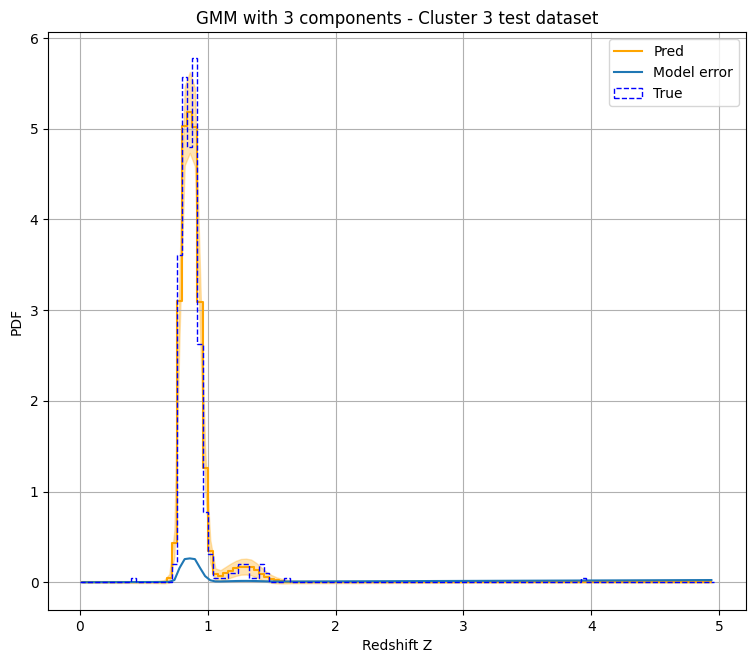

Chi^2: 2120.2628445427


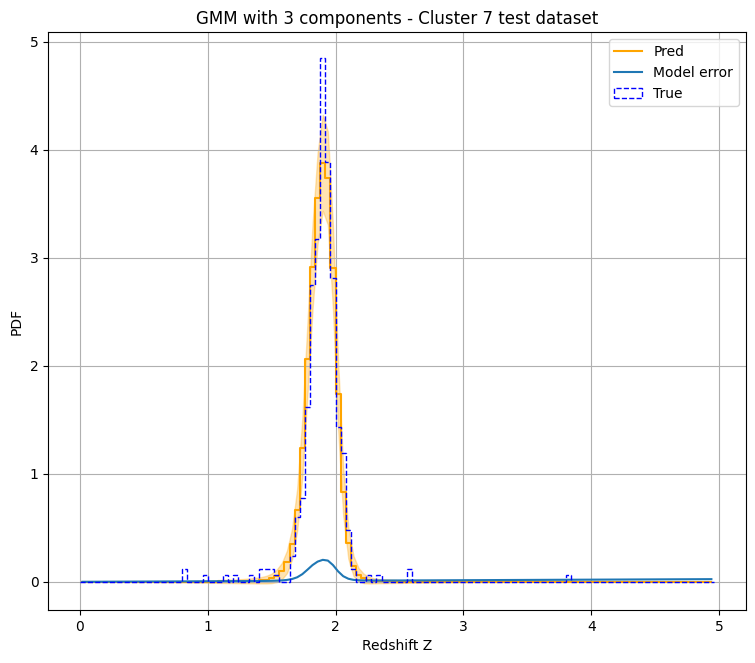

In [218]:
df["cluster"] = clusters
clusters = df["cluster"].value_counts().index.values

def return_cluster(df, cluster_num):
    df = df.loc[df["cluster"] == cluster_num]
    X, y = df.loc[:, features], df.loc[:, "Z"]
    X = scaler.transform(X)
    return X, y

for cluster in clusters:
    X, y = return_cluster(df, cluster)
    histPlotter = HistPlotter(X, y, f"Cluster {cluster}", model, "GMM")
    histPlotter.evaluate_model()